In [1]:
# TODO:  
%config Completer.use_jedi = False

In [2]:
%pylab inline
import gala.potential as gp
from gala.units import galactic, solarsystem, dimensionless
#import coefficients_smoothing
from bfe import coefficients
sys.path.append('../code/')
#from mwlmc_bfe import smooth_coeff
import coefficients_smoothing 
import bfe.ios as ios


Populating the interactive namespace from numpy and matplotlib


In [3]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

In [560]:
coeff_lmc_path = '../data/interim/BFE/MW_test/BFE_MWLMC5_b1_center_fix_sat_bound_snap'
coeff_mw_path =  '../data/interim/BFE/MW_test/BFE_LMC5_b1_center_fix_n25_l25_host_snap'
coeff_mwlmc_path = '../data/interim/BFE/MW_test/BFE_LMC5_b1_center_fix_n17_l17_2T_V_host_sat_unbound_snap'
coeff_mw_init =  '../data/interim/BFE/MW_test/BFE_MWLMC5_b1_center_fix_host_snap'

mass_host = 2.581e-05
mass_sat = 3.226e-05
mass_host_init = 1.297e-05
#mass = 1.577212515257997438e-06

nmax=20
lmax=20

In [561]:
S_lmc, T_lmc, SS_lmc, TT_lmc, ST_lmc = coefficients_smoothing.read_coeffcov_matrix(coeff_lmc_path, 0, 20, 20, 20, snaps=110, read_type=0)
S_mw, T_mw, SS_mw, TT_mw, ST_mw = coefficients_smoothing.read_coeffcov_matrix(coeff_mw_path, 0, 30, 25, 25, snaps=110, read_type=0)
S_mw_init, T_mw_init, SS_mw_init, TT_mw_init, ST_mw_init = coefficients_smoothing.read_coeffcov_matrix(coeff_mw_init, 0, 20, 20, 20, snaps=0, read_type=0)

S_mwlmc, T_mwlmc, SS_mwlmc, TT_mwlmc, ST_mwlmc = coefficients_smoothing.read_coeffcov_matrix(coeff_mwlmc_path, 0, nmax, lmax, lmax, snaps=110, read_type=0)

In [562]:
S_lmc_smooth, T_lmc_smooth, N = coefficients_smoothing.smooth_coeff_matrix(S_lmc, T_lmc, 
                                                                           SS_lmc, TT_lmc, ST_lmc, 
                                                                           mass_sat, 20, 20, 20, 10, 0)


S_mw_smooth, T_mw_smooth, N_mw = coefficients_smoothing.smooth_coeff_matrix(S_mw, T_mw, 
                                                                           SS_mw, TT_mw, ST_mw, 
                                                                           mass_host, 30, 25, 25, 4, 0)


S_mw_smooth_init, T_mw_smooth_init, N = coefficients_smoothing.smooth_coeff_matrix(S_mw_init, T_mw_init, 
                                                                           SS_mw_init, TT_mw_init, ST_mw_init, 
                                                                           mass_host_init, 20, 20, 20, 4, 0)

S_mwlmc_smooth, T_mwlmc_smooth, N_debris = coefficients_smoothing.smooth_coeff_matrix(S_mwlmc, T_mwlmc, 
                                                                           SS_mwlmc, TT_mwlmc, ST_mwlmc, 
                                                                           mass_host, nmax, lmax, lmax, 4, 0)

../code/coefficients_smoothing.py:128: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))


In [563]:
print(N_debris, N_mw)

159 114


<ipython-input-564-b0fd75adbdce>:1: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(np.abs(S_lmc_smooth[:,:,0].T)), origin='lower')


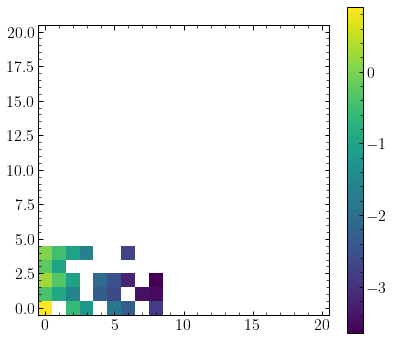

In [564]:
imshow(np.log10(np.abs(S_lmc_smooth[:,:,0].T)), origin='lower')
colorbar()

<ipython-input-565-0c2b81c5c9b2>:1: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(np.abs(S_mw_smooth[:,:,0].T)), origin='lower')


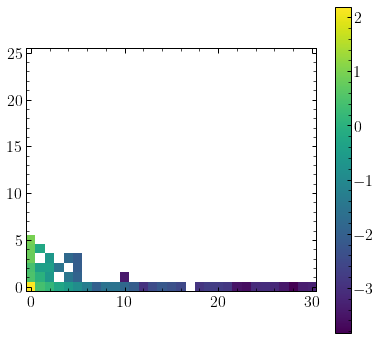

In [565]:
imshow(np.log10(np.abs(S_mw_smooth[:,:,0].T)), origin='lower')
colorbar()

In [566]:
S_mw_ref = S_mw_smooth_init
T_mw_ref = T_mw_smooth_init


S_mw_ref = np.zeros_like(S_mw_smooth)
T_mw_ref = np.zeros_like(T_mw_smooth)
S_mw_ref[0,0,0] = S_mw_smooth[0,0,0]
T_mw_ref[0,0,0] = T_mw_smooth[0,0,0]



S_mwlmc_ref = np.zeros_like(S_mwlmc_smooth)
T_mwlmc_ref = np.zeros_like(T_mwlmc_smooth)
S_mwlmc_ref[0,0,0] = S_mwlmc_smooth[0,0,0]
T_mwlmc_ref[0,0,0] = T_mwlmc_smooth[0,0,0]

In [567]:

def spherical_grid_shift(xyz, shift_com):
    x_shift = xyz[:,0] - shift_com[0]
    y_shift = xyz[:,1] - shift_com[1]
    z_shift = xyz[:,2] - shift_com[2]
    return np.ascontiguousarray(np.array([x_shift, y_shift, z_shift]).T)

def grid(box_size, nbins):
    y_grid = np.linspace(-box_size/2., box_size/2., nbins)
    z_grid = np.linspace(-box_size/2., box_size/2., nbins)
    nbins = len(y_grid)
    y_grid, z_grid = np.meshgrid(y_grid, z_grid)
    
    return y_grid, z_grid, nbins

def bfe_a_grid(S1, T1, y_grid, z_grid, rs):
    xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                             y_grid.flatten(),
                                             z_grid.flatten()]).T)
    
    a = biff.gradient(xyz, S1, T1, M=1, r_s=rs, G=1)
    a_mw = (a[:,0]**2 + a[:,1]**2 + a[:,2]**2)**0.5
    return a_mw

def bfe_rho_grid(S1, T1, y_grid, z_grid, rs, shift=0):
    xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                             y_grid.flatten(),
                                             z_grid.flatten()]).T)
    
    if shift==1:
        xyz = spherical_grid_shift(xyz, [-1.6172733999999993, -41.39907439, -27.93125875])
    
    rho_biff = gp.SCFPotential(m=1, Snlm=S1, Tnlm=T1, r_s=rs)
    rho = rho_biff.density(xyz.T)
    return rho

In [568]:
ygr, zgr, _ = grid(400, 100)
#a_wake = bfe_a_grid(S_mw_wake, T_mw_wake, ygr, zgr, 40.85)
#rho_wake = bfe_rho_grid(S_mw_wake, T_mw_wake, ygr, zgr, 40.85)
#rho_wake2 = bfe_rho_grid(S_mw/S_mw_ref, T_mw/T_mw_ref, ygr, zgr, 40.85)

In [569]:
#a_mw = bfe_a_grid(S_mw, T_mw, ygr, zgr, 40.85)
#a_mw_ref = bfe_a_grid(S_mw_ref, T_mw_ref, ygr, zgr, 40.85)

rho_mw = bfe_rho_grid(S_mw_smooth, T_mw_smooth, ygr, zgr, 40.85)
rho_mw_ref = bfe_rho_grid(S_mw_ref, T_mw_ref, ygr, zgr, 40.85)

In [570]:
rho_mwf = bfe_rho_grid(S_mwlmc_smooth, T_mwlmc_smooth, ygr, zgr, 40.85)
rho_mwlmc_ref = bfe_rho_grid(S_mwlmc_ref, T_mwlmc_ref, ygr, zgr, 40.85)
rho_lmc = bfe_rho_grid(S_lmc_smooth, T_lmc_smooth, ygr, zgr, 10, shift=1)


In [571]:
#LMC = ios.read_snap_coordinates('../../MW_anisotropy/code/test_snaps/', 'MWLMC5_100M_new_b1_110', 100000000, galaxy='sat')

In [572]:
# LMC orbit
orbit = np.loadtxt('../../MW_anisotropy/data/orbits/LMC5_100Mb0_orbit.txt')

In [596]:
lmc_wrt_mw = orbit[:140,6:9] - orbit[:140,0:3]

array([ -8.467121, -45.073927,  10.507275])

In [574]:
rp = np.random.randint(0, len(LMC[0]), 4000)

<ipython-input-637-c5c38b3b9483>:120: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax[1][0].annotate('', xy=(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2]),  xycoords='data',
<ipython-input-637-c5c38b3b9483>:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


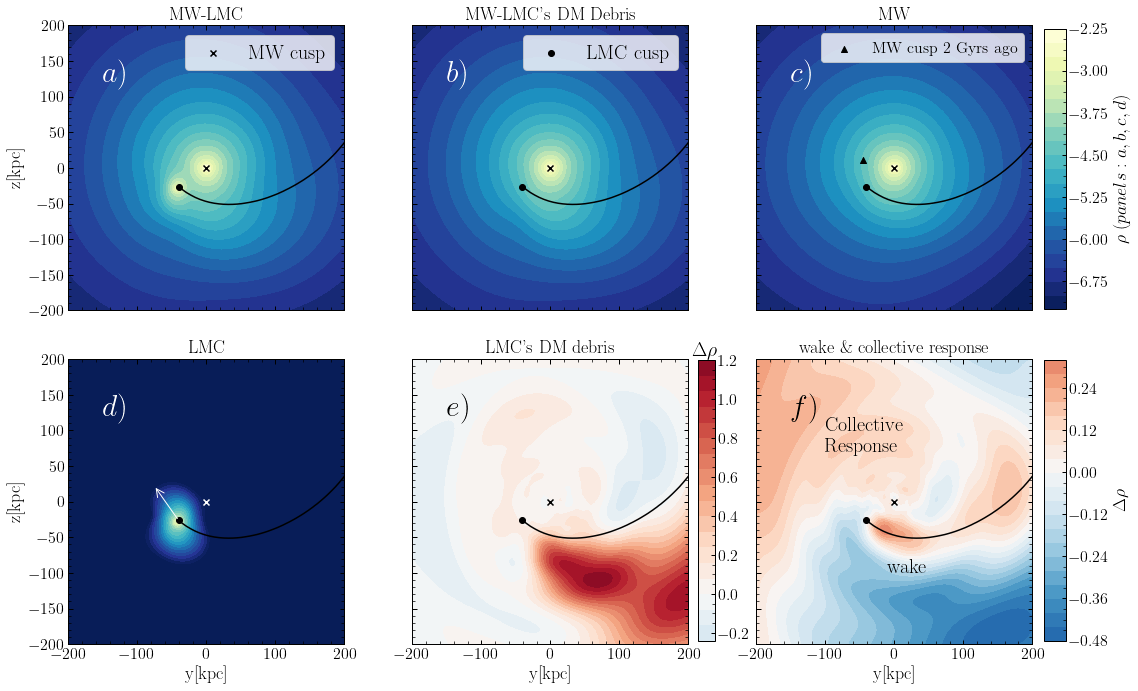

In [637]:

fig, ax = plt.subplots(2, 3, figsize=(15,10), sharex=True, sharey=True)

#title('MW with LMC')
im1 = ax[0][0].contourf(ygr, zgr, np.log10(np.abs((rho_lmc+rho_mwf).reshape(_, _))), 20
         , cmap='YlGnBu_r', vmin=-7.2, vmax=-2.3)
#scatter(-41, -28, c='k')
ax[0][0].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')

ax[0][0].set_ylabel('z[kpc]')
ax[1][0].set_ylabel('z[kpc]')

ax[1][0].set_xlabel('y[kpc]')
ax[1][1].set_xlabel('y[kpc]')
ax[1][2].set_xlabel('y[kpc]')

ax[0][0].plot(lmc_wrt_mw[:110,1], lmc_wrt_mw[:110,2], c='k')
ax[0][1].plot(lmc_wrt_mw[:110,1], lmc_wrt_mw[:110,2], c='k')
ax[0][2].plot(lmc_wrt_mw[:110,1], lmc_wrt_mw[:110,2], c='k')
ax[1][0].plot(lmc_wrt_mw[:110,1], lmc_wrt_mw[:110,2], c='k')
ax[1][1].plot(lmc_wrt_mw[:110,1], lmc_wrt_mw[:110,2], c='k')
ax[1][2].plot(lmc_wrt_mw[:110,1], lmc_wrt_mw[:110,2], c='k')


#subplot(2, 3, 2)
#title('MW with LMC debris')

ax[0][1].contourf(ygr, zgr, np.log10(np.abs((rho_mwf).reshape(_, _))), 20, cmap='YlGnBu_r', vmin=-7.2, vmax=-2.3)
#xlabel('y[kpc]')
ax[0][1].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k', label='LMC cusp')

#subplot(2, 3, 3)
#title('MW with LMC debris')

ax[0][2].contourf(ygr, zgr, np.log10(np.abs((rho_mw).reshape(_, _))), 20, cmap='YlGnBu_r', vmin=-7.2, vmax=-2.3)
#xlabel('y[kpc]')
ax[0][2].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')


#subplot(2, 3, 4)
#title('LMC')
im2 = ax[1][0].contourf(ygr, zgr, np.log10(np.abs((rho_lmc).reshape(_, _))), np.linspace(-6.2, -2.3, 20), 
                        cmap='YlGnBu_r', extend='both')
#xlabel('y[kpc]')
ax[1][0].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')


#subplot(2, 3, 5)
#title('LMC debris')
im3 = ax[1][1].contourf(ygr, zgr, (((rho_mwf/rho_mw).reshape(_, _)))-1, 20, cmap='RdBu_r', vmin=-1.3, vmax=1.3)
#colorbar()
#ax[1][1].scatter(LMC[0][rp, 1], LMC[0][rp, 2], c='k', s=0.1)

ax[1][1].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')
#ylabel('z[kpc]')
#xlabel('y[kpc]')

#subplot(2, 3, 6)
#title('Wake')
im4 = ax[1][2].contourf(ygr, zgr, (((rho_mw/rho_mw_ref).reshape(_, _)))-1, 20, cmap='RdBu_r', vmin=-0.6, vmax=0.62)
#colorbar()
ax[1][2].scatter(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2], c='k')
#xlabel('y[kpc]')

ax[0][0].text(-150, 120, '$a)$', color='w', fontsize=30)
ax[0][1].text(-150, 120, '$b)$', color='w', fontsize=30)
ax[0][2].text(-150, 120, '$c)$', color='w', fontsize=30)
ax[1][0].text(-150, 120, '$d)$', color='w', fontsize=30)
ax[1][1].text(-150, 120, '$e)$', color='k', fontsize=30)
ax[1][2].text(-150, 120, '$f)$', color='k', fontsize=30)


ax[1][1].set_xlim(-200, 200)
ax[1][1].set_ylim(-200, 200)

cax1 = fig.add_axes([0.98, 0.55, 0.02, 0.39]) 
cb1 = fig.colorbar(im1, cax=cax1)
cb1.set_label(r'$\rho\ (panels: a, b, c, d)$')

#cax2 = fig.add_axes([0.325, 0.09, 0.02, 0.41]) 
#cb2 = fig.colorbar(im2, cax=cax2)
#cb2.ax.tick_params(labelsize=15)
#cb2.set_label(r'$\rho$')


cax3 = fig.add_axes([0.66, 0.09, 0.015, 0.39]) 
cb3 = fig.colorbar(im3, cax=cax3, ticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
#cb3.set_label(r'$\Delta \rho$')
ax[1][1].text(205, 205, r'$\Delta \rho$')


cax4 = fig.add_axes([0.98, 0.09, 0.02, 0.39]) 
cb4 = fig.colorbar(im4, cax=cax4)
cb4.set_label(r'$\Delta \rho$')

ax[0][0].scatter(0, 0, c='k', marker='x', label='MW cusp')
ax[0][1].scatter(0, 0, c='k', marker='x')
ax[0][2].scatter(0, 0, c='k', marker='x')
ax[1][0].scatter(0, 0, c='w', marker='x')
ax[1][1].scatter(0, 0, c='k', marker='x')
ax[1][2].scatter(0, 0, c='k', marker='x')

ax[0][0].legend()
ax[0][1].legend()

ax[0][0].set_title('MW-LMC')
ax[0][1].set_title("MW-LMC's DM Debris")
ax[0][2].set_title('MW')
ax[1][0].set_title('LMC')
ax[1][1].set_title("LMC's DM debris")
ax[1][2].set_title('wake \& collective response')


ax[1][2].text(-10, -100, 'wake', color='k', fontsize=20)
ax[1][2].text(-100, 100, 'Collective', color='k', fontsize=20)
ax[1][2].text(-100, 70, 'Response', color='k', fontsize=20)

ax[0][2].scatter(-orbit[110, 1], -orbit[110, 2], c='k', marker='^', label='MW cusp 2 Gyrs ago')
ax[0][2].legend(fontsize=16)

ax[1][0].annotate('', xy=(lmc_wrt_mw[109,1], lmc_wrt_mw[109,2]),  xycoords='data',
        xytext=(lmc_wrt_mw[119,1], lmc_wrt_mw[119,2]), textcoords='data',
        arrowprops=dict(facecolor='white', arrowstyle='<-', color='white'))

fig.tight_layout()

savefig('fig1_v2.pdf', bbox_inches='tight')
savefig('fig1_v2.png', bbox_inches='tight')

#savefig('mw_lmc4_dens_bfe_v2.png', bbox_inches='tight')
#savefig('mw_lmc4_dens_bfe_v2.pdf', bbox_inches='tight')

## Make sure the plots are square, and fix the colorbar size


In [623]:
text?

##### ids_lmc = np.loadtxt('../data/interim/BFE/MW_test/MWLMC5_100M_new_b1_bound_sat_ids_110')

In [588]:
annotate?